In [11]:
'''Analisis.ipynb
'''
%pip install python-binance 
%pip install pandas 
%pip install matplotlib 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# BOT Mean Reversion
 implementado en Binance


In [1]:
from binance.client import Client
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

plt.style.use('dark_background')
matplotlib.rcParams['timezone'] = 'GMT-5'
import numpy as np
#%matplotlib inline
client = Client()

In [2]:
#HISTORICO 
candles = client.get_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1MINUTE, limit = 1000)

In [3]:
len(candles)

1000

In [4]:

price_df = pd.DataFrame(candles, columns=['dateTime',
                                          'open',
                                          'high', 'low',
                                          'close', 'volume',
                                          'closeTime', 
                                          'quoteAssetVolume',
                                          'numberOfTrades', 
                                          'takerBuyBaseVol', 
                                          'takerBuyQuoteVol', 'ignore'])
price_df.dateTime = pd.to_datetime(price_df.dateTime, unit='ms')
price_df.set_index('dateTime')
price_df.closeTime = pd.to_datetime(price_df.closeTime, unit='ms')
price_df.close = pd.to_numeric(price_df.close)
price_df.volume = pd.to_numeric(price_df.volume) 




In [6]:
#price_df.set_index('closeTime', inplace=True)
#closeprice = price_df['close'].to_numpy()

price_df['ma50'] = price_df.close.ewm(span=50).mean()

price_df['ma21'] = price_df.close.ewm(span=21).mean()

price_df.ma50 = pd.to_numeric(price_df.ma50)

price_df.ma21 = pd.to_numeric(price_df.ma21)

price_df.ma50

0      58769.890000
1      58787.291200
2      58808.338738
3      58817.384905
4      58829.289732
           ...     
995    60134.850092
996    60135.366167
997    60138.253768
998    60140.987738
999    60143.614493
Name: ma50, Length: 1000, dtype: float64

In [7]:
#RSI

rsi_period = 14

chg = price_df['close'].diff(1)

gain = chg.mask(chg<0,0)
price_df['gain'] = gain


loss = chg.mask(chg>0,0)
price_df['loss'] = loss

avg_gain = gain.ewm(com = rsi_period-1,min_periods=rsi_period).mean()
avg_loss = loss.ewm(com = rsi_period-1,min_periods=rsi_period).mean()

price_df['avg_gain'] = avg_gain
price_df['avg_loss'] = avg_loss

rs = abs(avg_gain/avg_loss)
rsi = 100 - (100 /(1 + rs) )
rsi



0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
995    51.876360
996    52.965212
997    60.064382
998    59.899954
999    59.899954
Name: close, Length: 1000, dtype: float64

In [8]:
## Para el Order Book
def difPct(bid, ask , pr):
  return ((ask - bid )/(pr/100))

client = Client()

order_book = client.futures_order_book(symbol = 'BTCUSDT', limit = 1000)
price_now = client.futures_mark_price(symbol = "BTCUSDT")

order_book = pd.DataFrame(order_book)
bids = pd.DataFrame(order_book['bids'])
asks = pd.DataFrame(order_book['asks'])
#float(asks.head(1)['asks'][0][0])
ask_min = float(asks['asks'].iloc[0][0])
bid_max = float(bids['bids'].iloc[0][0])
price = float(price_now['markPrice'])
dif_pct = difPct(bid_max, ask_min, price)
print( f' price {price} \n Diferencia : {ask_min- bid_max} \n Diferencia PCT: {dif_pct} ' ) 

prices_b = [float(x[0]) for x in order_book['bids']]
prices_a = [float(x[0]) for x in order_book['asks']]
qtts_b = [float(x[1]) for x in order_book['bids']]
qtts_a = [float(x[1]) for x in order_book['asks']]

p_b = pd.to_numeric(prices_b)
p_a = pd.to_numeric(prices_a)
q_b = pd.to_numeric(qtts_b)
q_a = pd.to_numeric(qtts_a)
b_M = q_b.max()
a_M = q_a.max()
bys = []
sls = []
for i in range (0, len(prices_b)) :
  if qtts_b[i] > b_M/2 :
    bys.append(prices_b[i])

for i in range (0, len(prices_a)) :
  if qtts_a[i] > a_M/2 :
    sls.append(prices_a[i])

print(f' compras:{bys} \n ventas: {sls}')


 price 60183.1 
 Diferencia : 0.09999999999854481 
 Diferencia PCT: 0.00016615960294259487 
 compras:[60183.0, 60122.4, 60108.2, 60052.0] 
 ventas: [60200.0, 60286.0]


/tmp/ipykernel_21347/3535269715.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.set_title(f"Precio { float( price_df.close.tail(1) ) } ")


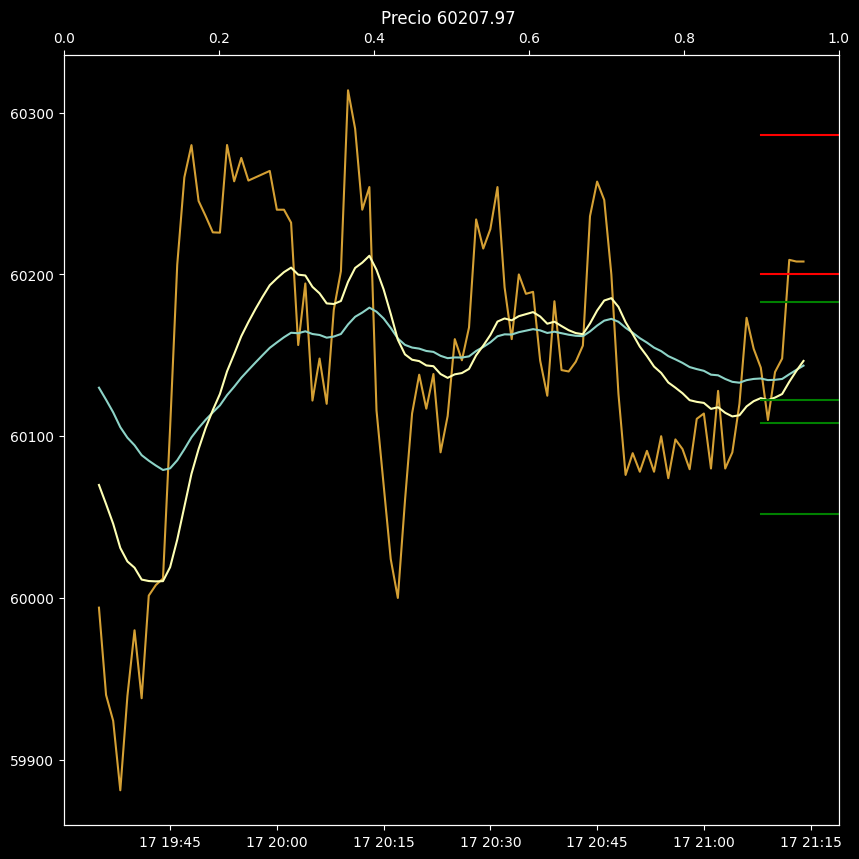

In [10]:
fig, ax = plt.subplots(1, figsize = (7,10))
tail = 100
ax.set_title(f"Precio { float( price_df.close.tail(1) ) } ")
ax.plot(price_df.closeTime.tail(tail),price_df.close.tail(tail), color = '#d5a034')
ax.plot(price_df.closeTime.tail(tail),price_df.ma50.tail(tail))

ax.plot(price_df.closeTime.tail(tail),price_df.ma21.tail(tail))
ax2 = ax.twiny()
# ax2.barh( price_df.close.tail(int(tail*2.0)), price_df.volume.tail(int(tail*2.0)), color=(0.2, 0.83, 0.6, 0.4) )
#ax[0].text(price_df['closeTime'].tail(1), float(price_df['close'].mean())*0.995, f"Last:\n{int(price_df['close'].tail(1))}", ha="center", va="center", size=15, bbox=dict(boxstyle="round,pad=0.3", fc="blue", ec="w", lw=2))   
for i in sls:
  ax.axhline(y=i, xmin=0.9, color="r")
for i in bys:
  ax.axhline(y=i, xmin=0.9 , color="g")




In [9]:
price_df.close



0      58747.07
1      58755.47
2      58740.01
3      58740.00
4      58779.98
         ...   
995    60128.00
996    60080.00
997    60089.96
998    60119.99
999    60199.99
Name: close, Length: 1000, dtype: float64